In [22]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from datasets import load_dataset

import nltk
# nltk.download('punkt')
from nltk.tokenize import word_tokenize
import torchtext

# get dataloader
from torch.utils.data import DataLoader
from torchtext.vocab import GloVe
from nltk.stem import PorterStemmer

In [23]:
nli_dataset = load_dataset("multi_nli")

Found cached dataset multi_nli (/home/prani/.cache/huggingface/datasets/multi_nli/default/0.0.0/591f72eb6263d1ab527561777936b199b714cda156d35716881158a2bd144f39)


  0%|          | 0/3 [00:00<?, ?it/s]

In [24]:
print(nli_dataset.shape)
train_dataset = nli_dataset["train"]
# validation_dataset = nli_dataset["validation"]
test_dataset = nli_dataset["validation_matched"]
print(train_dataset.shape)
# print(validation_dataset.shape)
print(test_dataset.shape)

# filter out samples with label -1 
train_dataset = train_dataset.filter(lambda example: example["label"] != -1)
# validation_dataset = validation_dataset.filter(lambda example: example["label"] != -1)
test_dataset = test_dataset.filter(lambda example: example["label"] != -1)

# remove all columns except premise, hypothesis and label
train_dataset = train_dataset.remove_columns(["promptID", "pairID", "premise_binary_parse", "premise_parse", "hypothesis_binary_parse", "hypothesis_parse", "genre"])
# validation_dataset = validation_dataset.remove_columns(["promptID", "pairID", "premise_binary_parse", "premise_parse", "hypothesis_binary_parse", "hypothesis_parse", "genre"])
test_dataset = test_dataset.remove_columns(["promptID", "pairID", "premise_binary_parse", "premise_parse", "hypothesis_binary_parse", "hypothesis_parse", "genre"])

print(train_dataset.shape)
# print(validation_dataset.shape)
print(test_dataset.shape)

Loading cached processed dataset at /home/prani/.cache/huggingface/datasets/multi_nli/default/0.0.0/591f72eb6263d1ab527561777936b199b714cda156d35716881158a2bd144f39/cache-75119ad20471c39d.arrow
Loading cached processed dataset at /home/prani/.cache/huggingface/datasets/multi_nli/default/0.0.0/591f72eb6263d1ab527561777936b199b714cda156d35716881158a2bd144f39/cache-04853eb0cd55f936.arrow


{'train': (392702, 10), 'validation_matched': (9815, 10), 'validation_mismatched': (9832, 10)}
(392702, 10)
(9815, 10)
(392702, 3)
(9815, 3)


In [25]:
# convert premise and hypothesis to lower
train_dataset = train_dataset.map(lambda example: {"premise": example["premise"].lower(), "hypothesis": example["hypothesis"].lower()})
# validation_dataset = validation_dataset.map(lambda example: {"premise": example["premise"].lower(), "hypothesis": example["hypothesis"].lower()})
test_dataset = test_dataset.map(lambda example: {"premise": example["premise"].lower(), "hypothesis": example["hypothesis"].lower()})
print(train_dataset.shape)

Loading cached processed dataset at /home/prani/.cache/huggingface/datasets/multi_nli/default/0.0.0/591f72eb6263d1ab527561777936b199b714cda156d35716881158a2bd144f39/cache-b447eeff54cb8c14.arrow
Loading cached processed dataset at /home/prani/.cache/huggingface/datasets/multi_nli/default/0.0.0/591f72eb6263d1ab527561777936b199b714cda156d35716881158a2bd144f39/cache-d867bbb04ff35afc.arrow


(392702, 3)


In [26]:
# tokenize premise and hypothesis and concatenate them using [SEP] token
train_dataset = train_dataset.map(lambda example: {"premise": word_tokenize(example["premise"]), "hypothesis": word_tokenize(example["hypothesis"])})
# validation_dataset = validation_dataset.map(lambda example: {"premise": word_tokenize(example["premise"]), "hypothesis": word_tokenize(example["hypothesis"])})
test_dataset = test_dataset.map(lambda example: {"premise": word_tokenize(example["premise"]), "hypothesis": word_tokenize(example["hypothesis"])})
print(train_dataset.shape)

# # perform stemming
# stemmer = PorterStemmer()
# train_dataset = train_dataset.map(lambda example: {"premise": [stemmer.stem(token) for token in example["premise"]], "hypothesis": [stemmer.stem(token) for token in example["hypothesis"]]})
# # validation_dataset = validation_dataset.map(lambda example: {"premise": [stemmer.stem(token) for token in example["premise"]], "hypothesis": [stemmer.stem(token) for token in example["hypothesis"]]})
# test_dataset = test_dataset.map(lambda example: {"premise": [stemmer.stem(token) for token in example["premise"]], "hypothesis": [stemmer.stem(token) for token in example["hypothesis"]]})
# print(train_dataset.shape)

# concatenate premise and hypothesis using [SEP] token
train_dataset = train_dataset.map(lambda example: {"premise": example["premise"] + ["[SEP]"] + example["hypothesis"]})
# validation_dataset = validation_dataset.map(lambda example: {"premise": example["premise"] + ["[SEP]"] + example["hypothesis"]})
test_dataset = test_dataset.map(lambda example: {"premise": example["premise"] + ["[SEP]"] + example["hypothesis"]})
print(train_dataset.shape)


Loading cached processed dataset at /home/prani/.cache/huggingface/datasets/multi_nli/default/0.0.0/591f72eb6263d1ab527561777936b199b714cda156d35716881158a2bd144f39/cache-dfb123b2ea8ea60e.arrow
Loading cached processed dataset at /home/prani/.cache/huggingface/datasets/multi_nli/default/0.0.0/591f72eb6263d1ab527561777936b199b714cda156d35716881158a2bd144f39/cache-ddf23b4751788ff5.arrow
Loading cached processed dataset at /home/prani/.cache/huggingface/datasets/multi_nli/default/0.0.0/591f72eb6263d1ab527561777936b199b714cda156d35716881158a2bd144f39/cache-f188b8b053b97678.arrow
Loading cached processed dataset at /home/prani/.cache/huggingface/datasets/multi_nli/default/0.0.0/591f72eb6263d1ab527561777936b199b714cda156d35716881158a2bd144f39/cache-c63c058826edb2f1.arrow


(392702, 3)
(392702, 3)


In [27]:
# remove the hypothesis column
train_dataset = train_dataset.remove_columns(["hypothesis"])
# validation_dataset = validation_dataset.remove_columns(["hypothesis"])
test_dataset = test_dataset.remove_columns(["hypothesis"])
print(train_dataset.shape)
print(train_dataset[0])

(392702, 2)
{'premise': ['conceptually', 'cream', 'skimming', 'has', 'two', 'basic', 'dimensions', '-', 'product', 'and', 'geography', '.', '[SEP]', 'product', 'and', 'geography', 'are', 'what', 'make', 'cream', 'skimming', 'work', '.'], 'label': 1}


In [28]:
# find the maximum length of the premise + hypothesis
max_length = max([len(example["premise"]) for example in train_dataset])
print(f'Maximum length of premise + hypothesis: {max_length}')
avg_length = np.mean([len(example["premise"]) for example in train_dataset])
print(f'Average length of premise + hypothesis: {avg_length}')

Maximum length of premise + hypothesis: 417
Average length of premise + hypothesis: 34.59753197080738


In [29]:
# percentage of samples with length less than 100
print(f'Percentage of samples with length less than 100: {np.mean([len(example["premise"]) < 100 for example in train_dataset])}')

Percentage of samples with length less than 100: 0.9940947588756869


In [30]:
# truncate the premise + hypothesis to 128 tokens and add padding to the end
train_dataset = train_dataset.map(lambda example: {"premise": example["premise"][:128] + ["[PAD]"] * (128 - len(example["premise"][:128]))})
# validation_dataset = validation_dataset.map(lambda example: {"premise": example["premise"][:128] + ["[PAD]"] * (128 - len(example["premise"][:128]))})
test_dataset = test_dataset.map(lambda example: {"premise": example["premise"][:128] + ["[PAD]"] * (128 - len(example["premise"][:128]))})

Loading cached processed dataset at /home/prani/.cache/huggingface/datasets/multi_nli/default/0.0.0/591f72eb6263d1ab527561777936b199b714cda156d35716881158a2bd144f39/cache-b29643cd0f99772a.arrow
Loading cached processed dataset at /home/prani/.cache/huggingface/datasets/multi_nli/default/0.0.0/591f72eb6263d1ab527561777936b199b714cda156d35716881158a2bd144f39/cache-ba1fd73ae093ab7e.arrow


In [31]:
# build vocabulary
vocabulary = torchtext.vocab.build_vocab_from_iterator([example["premise"] for example in train_dataset], specials=["[UNK]", "[PAD]", "[SEP]"], min_freq=5)
vocabulary.set_default_index(vocabulary["[UNK]"])

print(f'Vocabulary size: {len(vocabulary)}')
print(vocabulary.get_itos()[:10])

Vocabulary size: 48830
['[UNK]', '[PAD]', '[SEP]', 'the', '.', ',', 'to', 'of', 'and', 'a']


In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [36]:
# convert the tokens to indices
train_indices = train_dataset.map(lambda example: {"premise": torch.tensor([vocabulary[token] for token in example["premise"]], dtype=torch.long)})
# validation_dataset = validation_dataset.map(lambda example: {"premise": torch.tensor([vocabulary[token] for token in example["premise"]], dtype=torch.long)})
test_indices = test_dataset.map(lambda example: {"premise": torch.tensor([vocabulary[token] for token in example["premise"]], dtype=torch.long)})
print(train_indices.shape)
print(train_indices[0])

train_indices_only = np.array(train_indices["premise"])
print(train_indices_only.shape)
# validation_indices_only = np.array(validation_dataset["premise"])
# print(validation_indices_only.shape)
test_indices_only = np.array(test_indices["premise"])
print(test_indices_only.shape)

print(train_indices_only[0])

train_labels_only = np.array(train_dataset["label"])
print(train_labels_only.shape)
# validation_labels_only = np.array(validation_dataset["label"])
# print(validation_labels_only.shape)
test_labels_only = np.array(test_dataset["label"])
print(test_labels_only.shape)


Loading cached processed dataset at /home/prani/.cache/huggingface/datasets/multi_nli/default/0.0.0/591f72eb6263d1ab527561777936b199b714cda156d35716881158a2bd144f39/cache-a971036dd711c720.arrow
Loading cached processed dataset at /home/prani/.cache/huggingface/datasets/multi_nli/default/0.0.0/591f72eb6263d1ab527561777936b199b714cda156d35716881158a2bd144f39/cache-1e72b49a2ecca68e.arrow


(392702, 2)
{'premise': [21245, 3366, 9545, 42, 106, 1230, 8894, 758, 726, 8, 9273, 4, 2, 726, 8, 9273, 19, 57, 126, 3366, 9545, 109, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'label': 1}
(392702, 128)
(9815, 128)
[21245  3366  9545    42   106  1230  8894   758   726     8  9273     4
     2   726     8  9273    19    57   126  3366  9545   109     4     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     

In [39]:
print(train_indices_only.shape)
# print(validation_indices.shape)
print(test_indices_only.shape)

print(train_indices_only[0])
print(test_indices_only[0])

print(train_labels_only.shape)
# print(validation_labels.shape)
print(test_labels_only.shape)

print(train_labels_only[0])
print(test_labels_only[0])

(392702, 128)
(9815, 128)
[21245  3366  9545    42   106  1230  8894   758   726     8  9273     4
     2   726     8  9273    19    57   126  3366  9545   109     4     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1]
[   3   90  979   19  399  256    2  345   99 2031    3 6176  403    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1  

In [40]:
# batch the dataset
batch_size = 32
train_dataloader = DataLoader(list(zip(train_indices_only, train_labels_only)), batch_size=batch_size, shuffle=True)
# validation_dataloader = DataLoader(list(zip(validation_indices_only, validation_labels_only)), batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(list(zip(test_indices_only, test_labels_only)), batch_size=batch_size, shuffle=True)


In [41]:
# define the model as a sentence classifier using ELMO embeddings using two biLSTM layers and use glove embeddings for the words
class SentenceClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, num_classes=3, num_layers=2, dropout=0.5):
        super(SentenceClassifier, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.lstm1f = nn.LSTM(self.embedding_dim, self.hidden_dim, 1, bidirectional=False, batch_first=True, dropout=self.dropout)
        self.lstm1b = nn.LSTM(self.embedding_dim, self.hidden_dim, 1, bidirectional=False, batch_first=True, dropout=self.dropout)
        self.lstm2f = nn.LSTM(self.hidden_dim, self.hidden_dim, 1, bidirectional=False, batch_first=True, dropout=self.dropout)
        self.lstm2b = nn.LSTM(self.hidden_dim, self.hidden_dim, 1, bidirectional=False, batch_first=True, dropout=self.dropout)
        # self.lstm = nn.LSTM(self.embedding_dim, self.hidden_dim, self.num_layers, bidirectional=True, dropout=self.dropout)
        self.linear = nn.Linear(self.hidden_dim * 4 + self.embedding_dim, self.num_classes)
        self.dropout = nn.Dropout(self.dropout)

    def forward(self, x):
        # x.shape = (batch_size, max_length)
        embedded = self.embedding(x)
        # embedded.shape = (batch_size, max_length, embedding_dim)
        # print(embedded.shape)
        output1f, (hidden1f, cell1f) = self.lstm1f(embedded)
        output1b, (hidden1b, cell1b) = self.lstm1b(embedded.flip(dims = [1]))
        # output1b, (hidden1b, cell1b) = self.lstm1b(embedded)
        output2f, (hidden2f, cell2f) = self.lstm2f(output1f)
        output2b, (hidden2b, cell2b) = self.lstm2b(output1b)
        # output.shape = (batch_size, max_length, hidden_dim)
        
        # concatenate the forward and backward outputs for both layers
        output1 = torch.cat((output1f, output1b), dim=2)
        output2 = torch.cat((output2f, output2b), dim=2)
        # output.shape = (batch_size, max_length, hidden_dim * 2)

        # pass these outputs through a linear layer along with the initial embedding
        output = torch.cat((output1, output2, embedded), dim=2)
        # output.shape = (batch_size, max_length, hidden_dim * 4 + embedding_dim)
        output = self.linear(output)
        # output.shape = (batch_size, max_length, num_classes)
        output = output[:, -1, :]
        # output.shape = (batch_size, num_classes)
        output = self.dropout(output)
        return output    

In [43]:
# define the hyperparameters
embedding_dim = 300
hidden_dim = 256
vocab_size = len(vocabulary)
num_classes = 3
num_layers = 2
dropout = 0.5
learning_rate = 0.001
num_epochs = 10

# initialize the model
model = SentenceClassifier(embedding_dim, hidden_dim, vocab_size, num_classes, num_layers, dropout)
model.to(device)

# define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [45]:
# train the model
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    for batch in train_dataloader:
        # get the inputs and labels
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # calculate the statistics
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    # print the statistics
    print("Epoch: %d, Train Loss: %.3f, Train Accuracy: %.3f" % (epoch + 1, train_loss / len(train_dataloader), train_correct / train_total))

Epoch: 1, Train Loss: 1.060, Train Accuracy: 0.406
Epoch: 2, Train Loss: 0.980, Train Accuracy: 0.486
Epoch: 3, Train Loss: 0.943, Train Accuracy: 0.515
Epoch: 4, Train Loss: 0.914, Train Accuracy: 0.533
Epoch: 5, Train Loss: 0.886, Train Accuracy: 0.551
Epoch: 6, Train Loss: 0.857, Train Accuracy: 0.567
Epoch: 7, Train Loss: 0.827, Train Accuracy: 0.584
Epoch: 8, Train Loss: 0.803, Train Accuracy: 0.597
Epoch: 9, Train Loss: 0.776, Train Accuracy: 0.612
Epoch: 10, Train Loss: 0.749, Train Accuracy: 0.624


In [46]:
# evaluate the model
model.eval()
test_loss = 0
test_correct = 0
test_total = 0
for batch in test_dataloader:
    # get the inputs and labels
    inputs, labels = batch
    inputs = inputs.to(device)
    labels = labels.to(device)

    # forward
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    # calculate the statistics
    test_loss += loss.item()
    _, predicted = torch.max(outputs.data, 1)
    test_total += labels.size(0)
    test_correct += (predicted == labels).sum().item()

# print the statistics
print("Test Loss: %.3f, Test Accuracy: %.3f" % (test_loss / len(test_dataloader), test_correct / test_total))

# save the model
torch.save(model.state_dict(), "nli_model.pt")


Test Loss: 0.903, Test Accuracy: 0.596


               precision    recall  f1-score   support

   entailment       0.60      0.60      0.60      3479
      neutral       0.53      0.58      0.55      3123
contradiction       0.66      0.61      0.64      3213

     accuracy                           0.60      9815
    macro avg       0.60      0.60      0.60      9815
 weighted avg       0.60      0.60      0.60      9815



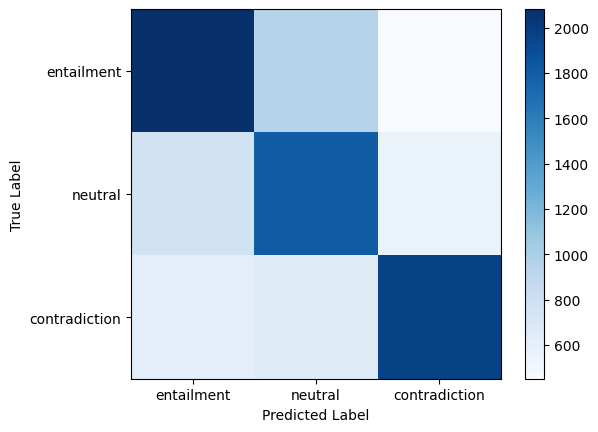

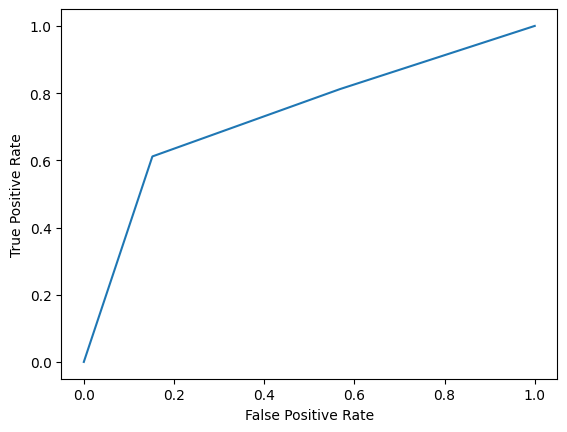

In [47]:
# get classificaiton report, confusion matrix, and ROC curve using sklearn
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

model.eval()
y_true = []
y_pred = []
for batch in test_dataloader:
    # get the inputs and labels
    inputs, labels = batch
    inputs = inputs.to(device)
    labels = labels.to(device)

    # forward
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)

    # append the labels
    y_true.extend(labels.tolist())
    y_pred.extend(predicted.tolist())

# print the classification report
print(classification_report(y_true, y_pred, target_names=["entailment", "neutral", "contradiction"]))

# plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks([0, 1, 2], ["entailment", "neutral", "contradiction"])
plt.yticks([0, 1, 2], ["entailment", "neutral", "contradiction"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# plot the ROC curve
y_true = np.array(y_true)
y_pred = np.array(y_pred)
fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=2)
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()



In [48]:
# load the model
model = SentenceClassifier(embedding_dim, hidden_dim, vocab_size, num_classes, num_layers, dropout)
model.load_state_dict(torch.load("nli_model.pt"))
model.to(device)

/home/prani/.local/lib/python3.10/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


SentenceClassifier(
  (embedding): Embedding(48830, 300)
  (lstm1f): LSTM(300, 256, batch_first=True, dropout=0.5)
  (lstm1b): LSTM(300, 256, batch_first=True, dropout=0.5)
  (lstm2f): LSTM(256, 256, batch_first=True, dropout=0.5)
  (lstm2b): LSTM(256, 256, batch_first=True, dropout=0.5)
  (linear): Linear(in_features=1324, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)